# Electricity Consumption Time Series Forecasting

This notebook implements a time series forecasting model for electricity consumption using PyTorch.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import zipfile
import os

## 1. Data Loading and Preprocessing

In [12]:
# Load the data
df_train = pd.read_csv('data\electricity_consump\electricity_consump\electricity_train.csv')
df_train['timestamp'] = pd.to_datetime(df_train['timestamp'])
df_train.set_index('timestamp', inplace=True)

df_test = pd.read_csv('data\electricity_consump\electricity_consump\electricity_test.csv')
df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])
df_test.set_index('timestamp', inplace=True)

df_train.head()

,consumption
timestamp,
2011-01-01 00:15:00,-0.704319
2011-01-01 00:30:00,-0.704319
2011-01-01 00:45:00,-0.678983
2011-01-01 01:00:00,-0.653647
2011-01-01 01:15:00,-0.704319


## 2. Data Exploration

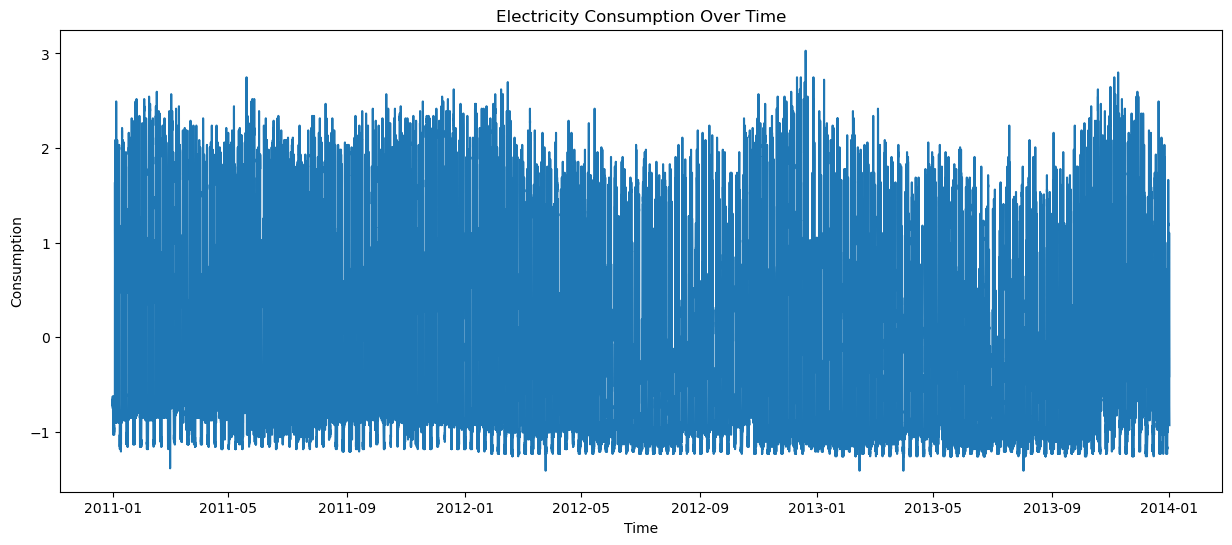

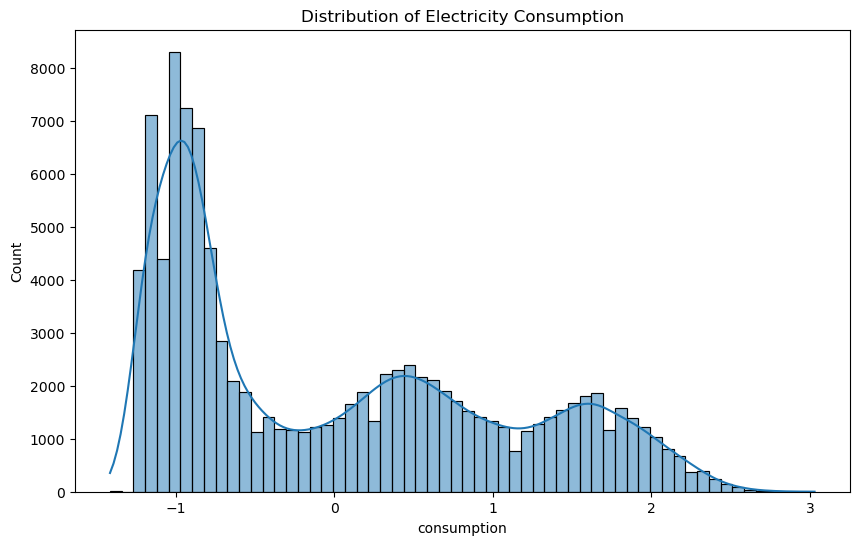

In [13]:
plt.figure(figsize=(15, 6))
plt.plot(df_train.index, df_train['consumption'])
plt.title('Electricity Consumption Over Time')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.show()

# Plot distribution of consumption
plt.figure(figsize=(10, 6))
sns.histplot(df_train['consumption'], kde=True)
plt.title('Distribution of Electricity Consumption')
plt.show()

## 3. Data Preprocessing

In [14]:
# Normalize the data
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(df_train[['consumption']])
scaled_test_data = scaler.transform(df_test[['consumption']])


# Create sequences for time series
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        targets.append(data[i+seq_length])
    return np.array(sequences), np.array(targets)

seq_length = 24  # Use 24 hours of data to predict next hour
X_train, y_train = create_sequences(scaled_train_data, seq_length)
X_test, y_test = create_sequences(scaled_test_data, seq_length)

## 4. PyTorch Dataset and DataLoader

In [15]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## 5. Model Definition

In [16]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

## 6. Training Loop

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            test_loss += criterion(y_pred, y_batch).item()
    
    train_loss /= len(train_loader)
    test_loss /= len(test_loader)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch [10/50], Train Loss: 0.0021, Test Loss: 0.0021
Epoch [20/50], Train Loss: 0.0019, Test Loss: 0.0024
Epoch [30/50], Train Loss: 0.0018, Test Loss: 0.0022
Epoch [40/50], Train Loss: 0.0018, Test Loss: 0.0022
Epoch [50/50], Train Loss: 0.0017, Test Loss: 0.0026


## 7. Plot Training Results

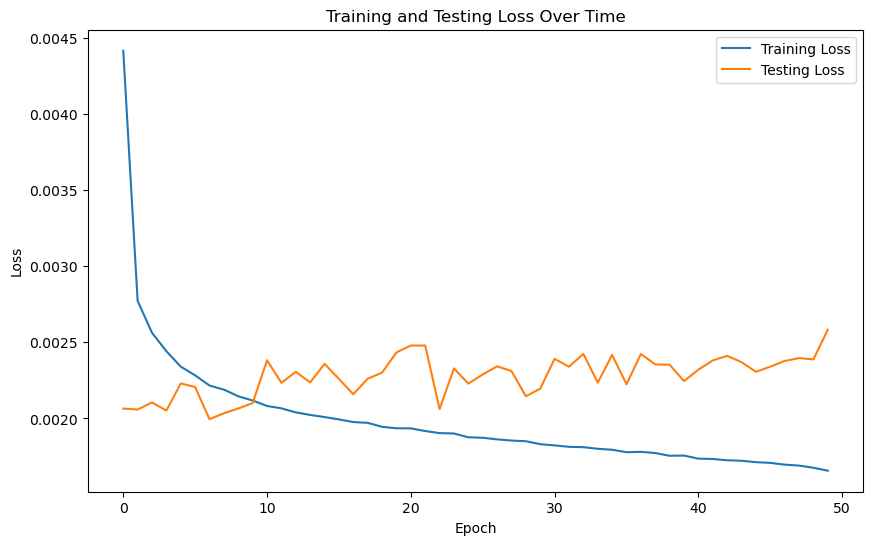

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.title('Training and Testing Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 8. Make Predictions

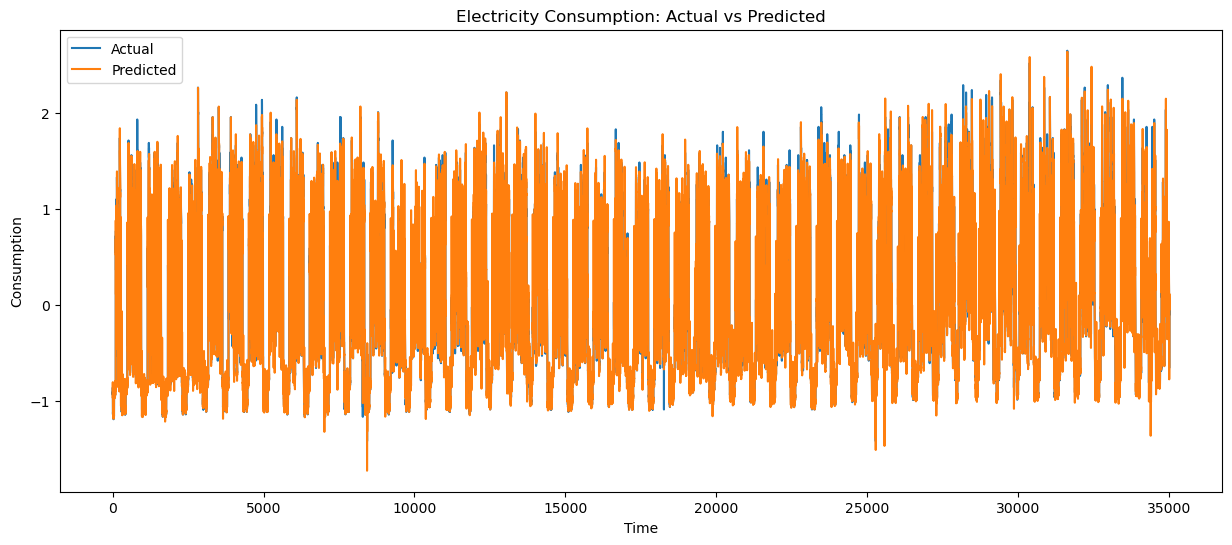

In [19]:
model.eval()
predictions = []
actual = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_pred = model(X_batch)
        predictions.extend(y_pred.cpu().numpy())
        actual.extend(y_batch.numpy())

predictions = np.array(predictions)
actual = np.array(actual)

# Inverse transform the predictions and actual values
predictions = scaler.inverse_transform(predictions)
actual = scaler.inverse_transform(actual)

# Plot predictions vs actual
plt.figure(figsize=(15, 6))
plt.plot(actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Electricity Consumption: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.legend()
plt.show()

## 9. Calculate Error Metrics

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(actual, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, predictions)
r2 = r2_score(actual, predictions)

print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'R-squared Score: {r2:.2f}')

Mean Squared Error: 0.05
Root Mean Squared Error: 0.23
Mean Absolute Error: 0.12
R-squared Score: 0.92
